In [4]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.signal import fftconvolve
from sympy import  DiracDelta
import matplotlib.pyplot as plt

In [5]:
def system(M, C, K, x0, xd0):
    M, C, K = np.array(M), np.array(C), np.array(K)

    Msi = np.linalg.inv(np.sqrt(M))

    w2, V = np.linalg.eig(Msi @ K @ Msi)   # w2 = ω²
    idx = np.argsort(np.abs(w2))
    w2 = w2[idx].real
    V  = V[:, idx]

    P = V

    sys = {
        'Msi':   Msi,
        'P':     P,
        'Cmod':  P.T @ Msi @ C @ Msi @ P,
        'Kmod':  P.T @ Msi @ K @ Msi @ P,
        'Fmod':  P.T @ Msi,
        'r0':    P.T @ np.sqrt(M) @ x0,
        'rd0':   P.T @ np.sqrt(M) @ xd0,
        'lambda': w2,                     # ← aqui é ω² (autovalores)
        'omega':  np.sqrt(w2),            # ← frequências naturais em rad/s
        'freq':   np.sqrt(w2)/(2*np.pi),  # ← em Hz
    }

        
    return sys

In [6]:
def fSS(t, r, m, c, k, F):
    u1, u2 = r
    u1d = u2
    u2d = (-c*u2 - k*u1 + F(t)) / m
    return [u1d, u2d]

In [17]:
def solve_mdof_num(t_eval, sys, f, method="RK45", rtol=1e-8, atol=1e-10):
    Cmod, Kmod, Fmod, r0, rd0 = sys['Cmod'], sys['Kmod'], sys['Fmod'], sys['r0'], sys['rd0']
    n = Cmod.shape[0]

    r, rd, rdd = [], [], []
    t0, tf = float(t_eval[0]), float(t_eval[-1])
    for i in range(n):
        y0 = np.hstack([r0[i], rd0[i]])

        def F(t):
            soma_linha = 0
            for j in range(n):
                soma_linha += Fmod[i][j]*f[j](t,0)
            return soma_linha
        
        m = 1
        c = Cmod[i][i]
        k = Kmod[i][i]

        sol = solve_ivp(
            fSS,
            (t0, tf),
            y0,
            method=method,
            t_eval=t_eval,
            args=(m, c, k, F)
        )
        
        r.append(sol['y'][0])
        rd.append(sol['y'][1])
        rdd.append((-c*sol['y'][1] - k*sol['y'][0] + F(t_eval))/m)
    
    r = np.array(r)
    rd = np.array(rd)
    rdd = np.array(rdd)

    x = sys['Msi'] @ sys['P'] @ r
    v = sys['Msi'] @ sys['P'] @ rd
    a = sys['Msi'] @ sys['P'] @ rdd

    return x, v, a

In [ ]:
def solve_phys_ode23(M, C, K, x0, xd0, f, t_eval):
    M, C, K = np.array(M), np.array(C), np.array(K) # C ja e array numpy
   
    n = M.shape[0]

    x, xd, xdd = [], [], []
    t0, tf = float(t_eval[0]), float(t_eval[-1])
    for i in range(n):
        y0 = np.hstack([x0[i], xd0[i]])

        def F(t):
            return f[i](t,0)
        
        m, c, k = 0, 0, 0
        for j in range(n):
            # print('j =', j, 'i =', i)
            m += M[j][i]
            c += C[j][i]
            print('K[j][i]', K[j][i])
            k += K[j][i]


        print(m,c,k)

        sol = solve_ivp(
            fSS,
            (t0, tf),
            y0,
            method='RK23',
            t_eval=t_eval,
            args=(m, c, k, F)
        )

        x.append(sol['y'][0])
        xd.append(sol['y'][1])
        xdd.append((-c*sol['y'][1] - k*sol['y'][0] + F(t_eval))/m)

    x = np.array(x)
    xd = np.array(xd)
    xdd = np.array(xdd)

    return x, xd, xdd

In [ ]:
def solve_phys_ode23(M, C, K, x0, xd0, f, t_eval):
    M, C, K = np.array(M), np.array(C), np.array(K)
    n = M.shape[0]

    Minv = np.linalg.inv(M)

    def f_phys(t):
        return np.array([fi(t, 0) for fi in f])

    def rhs(t, y):
        x = y[:n]
        v = y[n:]
        a = Minv @ (-C @ v - K @ x + f_phys(t))
        return np.hstack([v, a])

    t0, tf = float(t_eval[0]), float(t_eval[-1])
    y0 = np.hstack([np.ravel(x0), np.ravel(xd0)])

    sol = solve_ivp(rhs, (t0, tf), y0, method='RK23', t_eval=t_eval)

    print(f[0](1))

    x = sol.y[:n, :]
    v = sol.y[n:, :]
   
    vals = []
    for fi in f:
        vfi = np.asarray(fi(t_eval, 0), dtype=float)
        if vfi.ndim == 0:                      
            vfi = np.full_like(t_eval, vfi, dtype=float)  
        else:
            vfi = vfi.reshape(-1)             
        vals.append(vfi)
    Fmat = np.vstack(vals)                     

    a = Minv @ (-C @ v - K @ x + Fmat)

    return x, v, a

In [ ]:
def solve_mdof_analytic_mod(t_eval, sys, f, integration='convolucao'):
    Cmod, Kmod, Fmod, r0, rd0 = sys['Cmod'], sys['Kmod'], sys['Fmod'], sys['r0'], sys['rd0']
    n = Cmod.shape[0]
    t0 = float(t_eval[0])

    r_list, v_list, a_list = [], [], []

    for i in range(n):
        r0_i  = float(r0[i]); v0_i = float(rd0[i])

        Fi = lambda t: np.dot(Fmod[i, :],
                      np.array([fj(t, 0) for fj in f], dtype=float))

        omega = float(np.sqrt(Kmod[i, i]))
        zeta  = float(Cmod[i, i] / (2.0*omega))
        alpha = zeta*omega

        if zeta < 1:
            omegad = omega*np.sqrt(1 - zeta**2)
            
            rh  = np.exp(-alpha*t_eval)*( r0_i*np.cos(omegad*t_eval)
                   + (v0_i + alpha*r0_i)/omegad * np.sin(omegad*t_eval) )
            rdh = np.exp(-alpha*t_eval)*( 
                   -alpha*( r0_i*np.cos(omegad*t_eval) + (v0_i + alpha*r0_i)/omegad*np.sin(omegad*t_eval) )
                   - r0_i*omegad*np.sin(omegad*t_eval) + (v0_i + alpha*r0_i)*np.cos(omegad*t_eval) )
            
            h    = lambda dt: (np.exp(-alpha*dt)*np.sin(omegad*dt)/omegad) if dt>=0 else 0.0
            hdot = lambda dt: (np.exp(-alpha*dt)*(np.cos(omegad*dt) - (alpha/omegad)*np.sin(omegad*dt))) if dt>=0 else 0.0

        elif zeta > 1:
            s  = np.sqrt(zeta**2 - 1.0)
            r1 = -omega*(zeta - s); r2 = -omega*(zeta + s)
            C1 = (v0_i - r2*r0_i)/(r1 - r2); C2 = (r1*r0_i - v0_i)/(r1 - r2)
            rh  = C1*np.exp(r1*t_eval) + C2*np.exp(r2*t_eval)
            rdh = C1*r1*np.exp(r1*t_eval) + C2*r2*np.exp(r2*t_eval)
            h    = lambda dt: ((np.exp(r1*dt) - np.exp(r2*dt))/(r1 - r2)) if dt>=0 else 0.0
            hdot = lambda dt: ((r1*np.exp(r1*dt) - r2*np.exp(r2*dt))/(r1 - r2)) if dt>=0 else 0.0

        else:
            rh  = np.exp(-omega*t_eval)*( r0_i + (v0_i + omega*r0_i)*t_eval )
            rdh = np.exp(-omega*t_eval)*( (v0_i + omega*r0_i) - omega*(r0_i + (v0_i + omega*r0_i)*t_eval) )
            h    = lambda dt: (dt*np.exp(-omega*dt)) if dt>=0 else 0.0
            hdot = lambda dt: (np.exp(-omega*dt)*(1 - omega*dt)) if dt>=0 else 0.0

        # --- convoluções ---
        if integration=='convolucao':
            dt = t_eval[1] - t_eval[0]
            F_s = np.array([Fi(t) for t in t_eval])

            h_s    = np.array([h(t)    for t in t_eval])
            hdot_s = np.array([hdot(t) for t in t_eval])

            rp = dt * fftconvolve(h_s,    F_s, mode="full")[:len(t_eval)]
            vp = dt * fftconvolve(hdot_s, F_s, mode="full")[:len(t_eval)]
        elif integration=='integral':
            rp  = np.empty_like(t_eval); vp = np.empty_like(t_eval)
            for k, tk in enumerate(t_eval):
                integ_r  = lambda tau: h(tk - tau)    * Fi(tau)
                integ_v  = lambda tau: hdot(tk - tau) * Fi(tau)
                rp[k] = quad(integ_r, t0, float(tk), limit=200)[0]
                vp[k] = quad(integ_v, t0, float(tk), limit=200)[0]

        r = rh + rp
        v = rdh + vp
        
        Fe = np.array([Fi(tk) for tk in t_eval], dtype=float)
        a = -2.0*zeta*omega*v - (omega**2)*r + Fe

        r_list.append(r); v_list.append(v); a_list.append(a)

    r  = np.vstack(r_list)  
    v  = np.vstack(v_list)
    a  = np.vstack(a_list)

    # volta ao espaço físico
    x = sys['Msi'] @ sys['P'] @ r
    v_phys = sys['Msi'] @ sys['P'] @ v
    a_phys = sys['Msi'] @ sys['P'] @ a

    return x, v_phys, a_phys


In [7]:
# Exemplo MatLab Nabarrete

M = [[100]]
C = [[100]]
K = [[910]]
x0 = [[0.001]]
xd0 = [[0.02]]

t = np.arange(0, 20, 0.001) # deixaremos a escolhe do tempo assim, por enquanto
f = [lambda t, s: 10*np.cos(3*t)]

sys = system(M, C, K, x0, xd0)

x_num, v_num, a_num = solve_mdof_num(t, sys, f)
x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f, integration='convolucao')

C:\Users\ymarc\AppData\Local\Temp\ipykernel_6300\2886369549.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])


In [184]:
# Exemplo 4.9.2 Inman

M = [[1, 0], [0, 4]]
C = [[0,0], [0,0]]
K = [[12, -2], [-2, 12]]
x0 = [[1], [1]]
xd0 = [[0], [1]]

dt = 0.01
t = np.arange(0, 20, dt) # deixaremos a escolhe do tempo assim, por enquanto
f = [lambda t, s: (1.0/(np.sqrt(2*np.pi)*dt)) * np.exp(-t**2/(2*dt**2)),
     lambda t, s: 0]

sys = system(M, C, K, x0, xd0)
x_num, v_num, a_num = solve_mdof_num(t, sys, f)
x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f, integration='convolucao')

C:\Users\ymarc\AppData\Local\Temp\ipykernel_13672\2775662885.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])


In [182]:
# Exemplo 4.10.3 Inman

M = [[2, 0], [0, 1]]
C = [[0.3, -0.05], [-0.05, 0.05]]
K = [[3, -1], [-1, 1]]
x0 = [[0], [-0.1]]
xd0 = [[0], [0]]

dt = 0.001
t = np.arange(0, 30, dt) # deixaremos a escolhe do tempo assim, por enquanto
f = [lambda t, s: 0,
     lambda t, s: np.where((t >= 1) & (t < 1.1), 1.0, 0.0)]

sys = system(M, C, K, x0, xd0)

x_num, v_num, a_num = solve_mdof_num(t, sys, f)
x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f, integration='convolucao')

C:\Users\ymarc\AppData\Local\Temp\ipykernel_23548\2886369549.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])


In [58]:
# P1 Q4
m, E, I, l = (55300+79800)/(6*2), 75e9, 1e-2, 10
k = E*I / (l**3)
M = m * np.array([
    [1,0,0],
    [0,4,0],
    [0,0,1]
])
C = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]
])
K = k * np.array([
    [3,-3,0],
    [-3,6,-3],
    [0,-3,3]
])
x0 = np.array([[0],[0],[0]])
xd0 = np.array([[0],[0],[0]])

w =
 [[0.         0.         0.        ]
 [0.         1.73205081 0.        ]
 [0.         0.         2.12132034]] 
=
 [[ 0.          0.          0.        ]
 [ 0.         14.1369007   0.        ]
 [ 0.          0.         17.31409663]]

f =
 [[0.         0.         0.        ]
 [0.         2.24995763 0.        ]
 [0.         0.         2.75562406]]

 phi =
 [[ 3.84757703e-03 -6.66419890e-03  5.44129562e-03]
 [ 3.84757703e-03 -1.82875636e-18 -2.72064781e-03]
 [ 3.84757703e-03  6.66419890e-03  5.44129562e-03]]


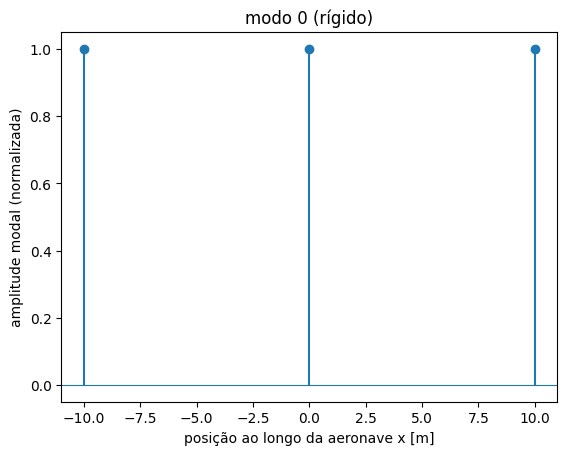

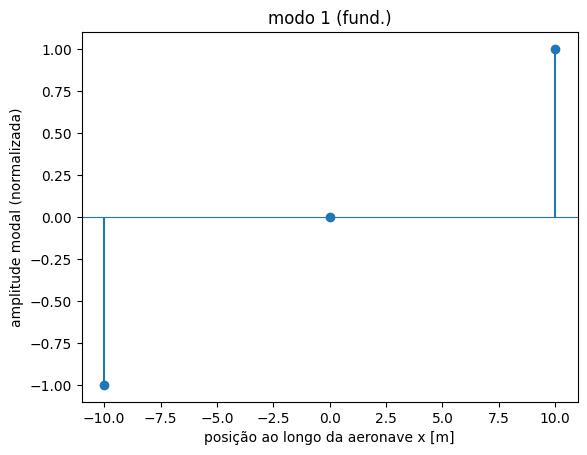

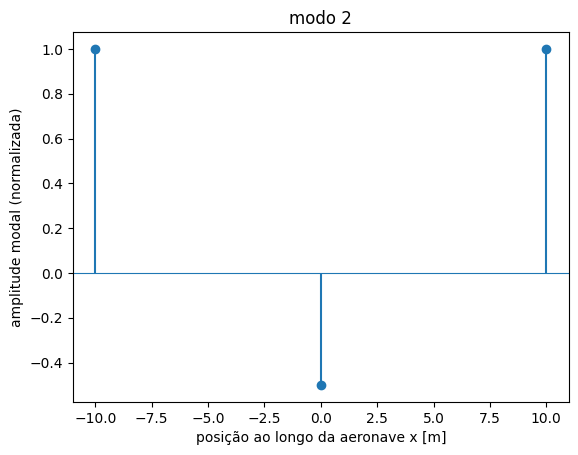

In [11]:
def itemA():
    dt = 0.001
    tf = 1
    t = np.arange(0, tf, dt)

    eps = dt
    delta = lambda t: (1/(eps*np.sqrt(np.pi)))*np.exp(-(t/eps)**2)
    f = [lambda t,s=0: 0.0,    # x1: direita
         lambda t,s=0:  0.0,         # x2: cabine
         lambda t,s=0:  0.0]   # x3: esquerda
    sys = system(M, C, K, x0, xd0)

    # Respostas:

    wi = np.diag(sys['omega'])

    print('w =\n', wi*np.sqrt(m/k), '\n=\n', wi)
    print('\nf =\n', wi / (2*np.pi))

    Phi = sys['Msi']@sys['P']
    print('\n phi =\n', Phi)

    # normalização por massa
    for j in range(Phi.shape[1]):
        Phi[:, j] /= np.sqrt(Phi[:, j].T @ M @ Phi[:, j])

    # para visualização, normalizar cada modo pelo máximo absoluto
    Phi_plot = Phi / np.max(np.abs(Phi), axis=0, keepdims=True)

    # posições dos GDL
    pos = np.array([-l, 0, +l])   # [m]

    modos = ["modo 0 (rígido)", "modo 1 (fund.)", "modo 2"]
    for j, label in enumerate(modos):
        plt.stem(pos, Phi_plot[:, j], basefmt=" ")  
        plt.axhline(0, linewidth=0.8)
        plt.xlabel("posição ao longo da aeronave x [m]")
        plt.ylabel("amplitude modal (normalizada)")
        plt.title(label)
        plt.savefig(f'{modos[j]}.png')
        plt.show()

itemA()

C:\Users\ymarc\AppData\Local\Temp\ipykernel_28744\2775662885.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])
C:\Users\ymarc\AppData\Local\Temp\ipykernel_28744\2775662885.py:15: RuntimeWarning: invalid value encountered in sqrt
  omega = float(np.sqrt(Kmod[i, i]))


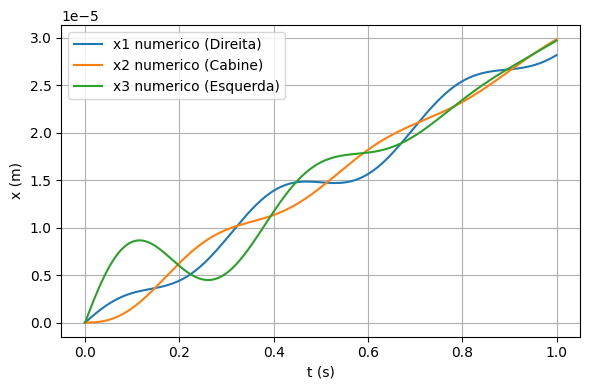

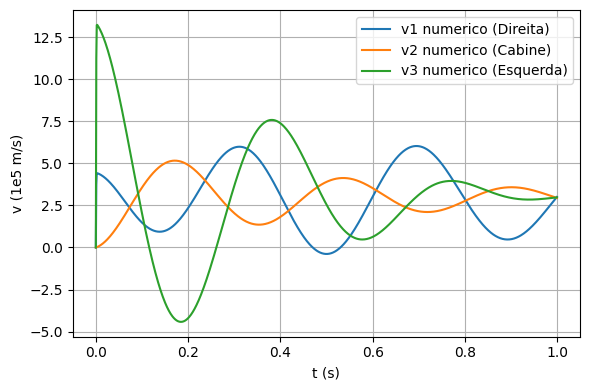

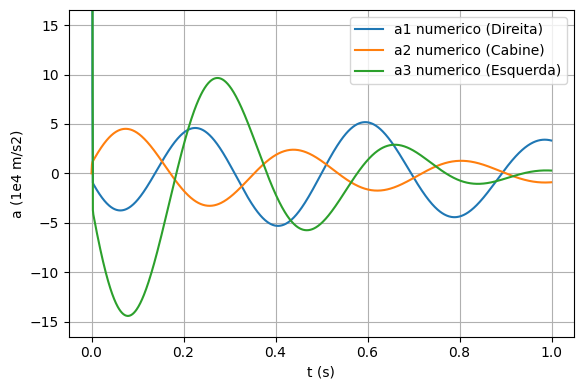

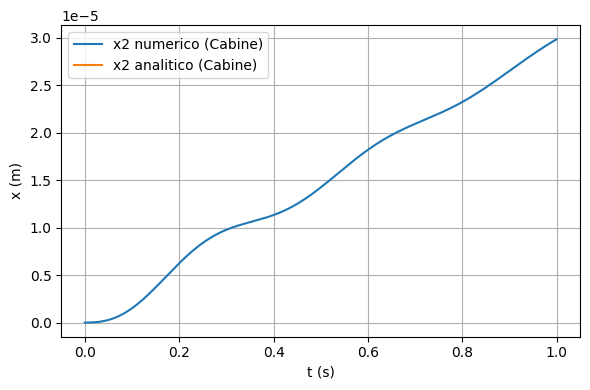

In [13]:
def itemB():
    dt = 0.001
    tf = 1
    t = np.arange(0, tf, dt)

    eps = dt
    delta = lambda t: (1/(eps*np.sqrt(np.pi)))*np.exp(-(t/eps)**2)
    f = [lambda t,s=0: delta(t),    # x1: direita
         lambda t,s=0:  0.0,         # x2: cabine
         lambda t,s=0:  3*delta(t)]   # x3: esquerda
    sys = system(M, C, K, x0, xd0)

    omega = sys['omega']
    zeta  = 0.1
    sys['Cmod'] = np.diag(2*zeta*omega)     # amortecimento modal

    x_num, v_num, a_num = solve_mdof_num(t, sys, f)
    x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f)

    # Resultados em gráficos
    plt.figure(figsize=(6,4))
    plt.plot(t,     x_num[0], '-',      label='x1 numerico (Direita)')
    plt.plot(t,     x_num[1], '-',      label='x2 numerico (Cabine)')
    plt.plot(t,     x_num[2], '-',      label='x3 numerico (Esquerda)')
    plt.xlabel('t (s)'); plt.ylabel('x (m)'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig('deslocamento.png')
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(t,     1e5*v_num[0], '-',      label='v1 numerico (Direita)')
    plt.plot(t,     1e5*v_num[1], '-',      label='v2 numerico (Cabine)')
    plt.plot(t,     1e5*v_num[2], '-',      label='v3 numerico (Esquerda)')
    plt.xlabel('t (s)'); plt.ylabel('v (1e5 m/s)'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig('velocidade.png')
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(t,     1e4*a_num[0], '-',      label='a1 numerico (Direita)')
    plt.plot(t,     1e4*a_num[1], '-',      label='a2 numerico (Cabine)')
    plt.plot(t,     1e4*a_num[2], '-',      label='a3 numerico (Esquerda)')
    plt.xlabel('t (s)'); plt.ylabel('a (1e4 m/s2)'); plt.grid(True); plt.legend(); plt.tight_layout()
    a_max = max(1e4*a_num[0][2:])
    plt.ylim(-2*a_max, 2*a_max)
    plt.savefig('aceleracao.png')
    plt.show()

    # Analise da cabine
    plt.figure(figsize=(6,4))
    plt.plot(t,     x_num[1], '-',      label='x2 numerico (Cabine)')
    plt.plot(t,     x_analityc[1], '-',      label='x2 analitico (Cabine)')
    plt.xlabel('t (s)'); plt.ylabel('x (m)'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig('deslocamento_cabine.png')
    plt.show()
    
itemB()

C:\Users\ymarc\AppData\Local\Temp\ipykernel_28744\2775662885.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])
C:\Users\ymarc\AppData\Local\Temp\ipykernel_28744\2775662885.py:15: RuntimeWarning: invalid value encountered in sqrt
  omega = float(np.sqrt(Kmod[i, i]))


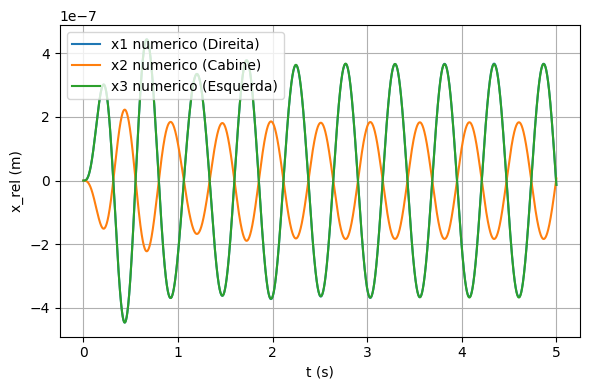

In [14]:
def itemC():
    dt = 0.001
    tf = 5
    t = np.arange(0, tf, dt)

    F0=1
    f = [lambda t,s=0: F0*np.sin(12*t),    # x1: direita
         lambda t,s=0:  0.0,         # x2: cabine
         lambda t,s=0:  F0*np.sin(12*t)]   # x3: esquerda
    sys = system(M, C, K, x0, xd0)

    omega = sys['omega']
    zeta  = 0.1
    sys['Cmod'] = np.diag(2*zeta*omega)     # amortecimento modal

    x_num, v_num, a_num = solve_mdof_num(t, sys, f)
    x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f)

    # --- remover corpo rígido no espaço físico ---
    Mmat = np.asarray(M, dtype=float)    # <- NÃO reusar o nome M
    n = Mmat.shape[0]
    one = np.ones((n, 1))

    # α(t) = (1^T M x) / (1^T M 1)
    alpha = (one.T @ Mmat @ x_num) / (one.T @ Mmat @ one)   # (1, N)
    x_rel = x_num - one @ alpha

    # Resultados em gráficos
    plt.figure(figsize=(6,4))
    plt.plot(t,     x_rel[0], '-',      label='x1 numerico (Direita)')
    plt.plot(t,     x_rel[1], '-',      label='x2 numerico (Cabine)')
    plt.plot(t,     x_rel[2], '-',      label='x3 numerico (Esquerda)')
    # plt.plot(t,     F0*np.sin(12*t), '-', label='Excitação F = F0*sin(12t)')
    plt.xlabel('t (s)'); plt.ylabel(f'x_rel (m)'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig('deslocamento_F0.png')
    plt.show()

itemC()

0.0


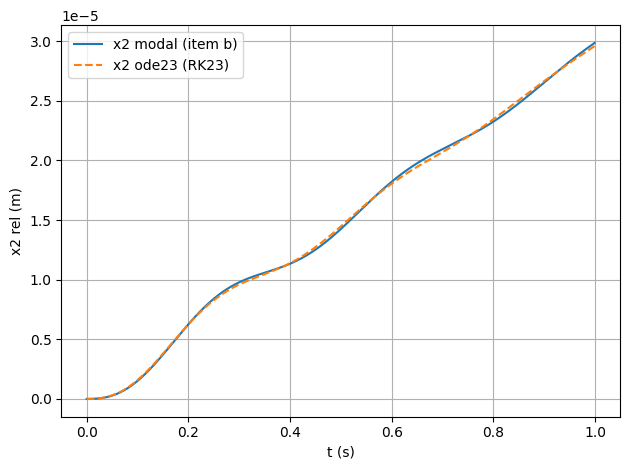

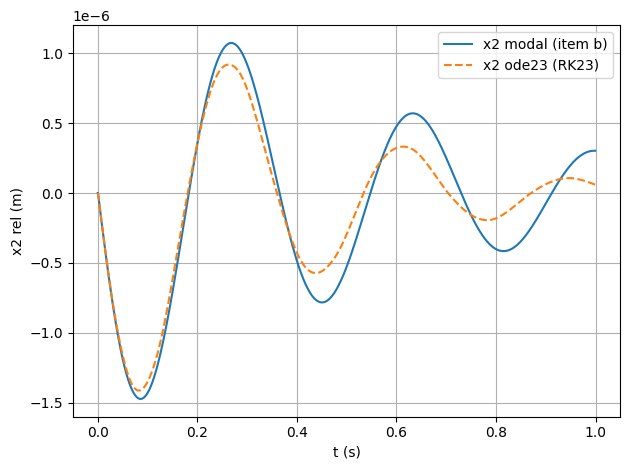

In [95]:
def itemD():
    # (b) força: delta na direita e 3delta na esquerda
    dt = 0.001
    tf = 1
    t = np.arange(0, tf, dt)
    eps = dt
    delta = lambda t: (1/(eps*np.sqrt(np.pi))) * np.exp(-(t/eps)**2)
    f_b = [lambda t,s=0: delta(t),  lambda t,s=0: 0.0,  lambda t,s=0: 3*delta(t)]

    sys = system(M, C, K, x0, xd0) 

    omega = sys['omega']
    zeta  = 0.1
    sys['Cmod'] = np.diag(2*zeta*omega)     # amortecimento modal

    # análise modal 
    x_modal, v_modal, a_modal = solve_mdof_num(t, sys, f_b)

    # ode23 físico
    C0 = np.linalg.inv(sys['Msi']) @ sys['P'] @ sys['Cmod'] @ sys['P'].T @ np.linalg.inv(sys['Msi'])
    x_ode23, v_ode23, a_ode23 = solve_phys_ode23(M, C0, K, x0, xd0, f_b, t)

    plt.figure()
    plt.plot(t, x_modal[1], label='x2 modal (item b)')
    plt.plot(t, x_ode23[1], '--', label='x2 ode23 (RK23)')
    plt.xlabel('t (s)'); plt.ylabel('x2 rel (m)'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig('ModalxODE23.png')
    plt.show()

    # Remover corpo-rígido para comparar como no (b)
    one  = np.ones((M.shape[0],1))
    alpha_modal = (one.T @ M @ x_modal)/(one.T @ M @ one)
    alpha_ode23 = (one.T @ M @ x_ode23)/(one.T @ M @ one)
    x2_modal_rel = (x_modal - one @ alpha_modal)[1]
    x2_ode23_rel = (x_ode23 - one @ alpha_ode23)[1]

    plt.figure()
    plt.plot(t, x2_modal_rel, label='x2 modal (item b)')
    plt.plot(t, x2_ode23_rel, '--', label='x2 ode23 (RK23)')
    plt.xlabel('t (s)'); plt.ylabel('x2 rel (m)'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig('ModalxODE23_sCorpoRigido.png')
    plt.show()

itemD()